In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_fscore_support
)

from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

2025-12-12 13:50:37.099744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765547437.368127      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765547437.446261      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.config.experimental.enable_op_determinism()

# **Loading Processed Data**

In [3]:
!git clone https://github.com/rahmamohax/Geasture-Recognition.git

Cloning into 'Geasture-Recognition'...
remote: Enumerating objects: 820, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 820 (delta 0), reused 3 (delta 0), pack-reused 816 (from 2)
Receiving objects: 100% (820/820), 348.20 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (794/794), done.


In [4]:
# Configuration

IMG_SIZE = 256
BATCH_SIZE = 16
HEAD_LR = 1e-3
FT_LR = 1e-5
HEAD_EPOCHS = 15
FT_EPOCHS = 10
UNFREEZE_LAST_LAYERS = 50

BASE_PATH = "Geasture-Recognition/" 
CSV_PATH = os.path.join(BASE_PATH, "processed_dataset/videos_metadata.csv")

### **Loading Metadata**

In [5]:
df = pd.read_csv(CSV_PATH)

df["file_path"] = df["file_path"].apply(lambda p: os.path.join(BASE_PATH, p))
df["file_path"] = df["file_path"].str.replace("\\", "/", regex=False)
df = df.sort_values("file_path").reset_index(drop=True)

num_classes = df["label"].nunique()
print("Classes:", num_classes)

Classes: 5


### **Loading .npy Video**

In [6]:
def load_npy(path):
    path = path.numpy().decode() 
    path = os.path.normpath(path) 
    arr = np.load(path)
    return arr.astype(np.float32)


def tf_load_npy(path):
    arr = tf.py_function(func=load_npy, inp=[path], Tout=tf.float32)
    arr.set_shape([30, 64, 64, 3]) 
    return arr

### **Frames Preprocessing**

In [7]:
def preprocess_video(frames):
    # Scale frames if needed
    max_v = tf.reduce_max(frames)
    frames = tf.cond(max_v <= 1.1, lambda: frames * 255., lambda: frames)

    # Resize all frames 
    frames = tf.image.resize(frames, (IMG_SIZE, IMG_SIZE))

    f1 = frames[0]
    fM = frames[len(frames)//2]
    fL = frames[-1]


    img = (f1 + fM + fL) / 3.0

    return preprocess_input(img)


### **Data Pipeline**

In [8]:
def build_ds(split):
    sub = df[df["split"] == split]

    paths = sub["file_path"].values
    labels = sub["label"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if split == "train":
        ds = ds.shuffle(5000, seed=SEED)


    ds = ds.map(lambda p, l: (tf_load_npy(p), l), num_parallel_calls=1)
    ds = ds.map(lambda fr, l: (preprocess_video(fr), tf.cast(l, tf.int32)), num_parallel_calls=1)

    ds = ds.batch(BATCH_SIZE).prefetch(1)
    return ds

train_ds = build_ds("train")
val_ds   = build_ds("val")
test_ds  = build_ds("test")

2025-12-12 13:59:54.766585: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# **ResNet Model**

### **Freeze Early Layers**

In [9]:
base = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="avg")
base.trainable = False  # freeze initially

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(HEAD_LR),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### **Train Classifier Head**

In [10]:
cb = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=2)
]

hist_head = model.fit(train_ds, validation_data=val_ds, epochs=HEAD_EPOCHS, callbacks=cb)

Epoch 1/15


2025-12-12 14:00:41.637187: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_9}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2590 - loss: 1.7343

2025-12-12 14:01:57.614559: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_4}}


35/35 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.2613 - loss: 1.7290 - val_accuracy: 0.4435 - val_loss: 1.3120 - learning_rate: 0.0010
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6541 - loss: 1.0074 - val_accuracy: 0.6000 - val_loss: 1.0518 - learning_rate: 0.0010
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7653 - loss: 0.7785 - val_accuracy: 0.6435 - val_loss: 0.9447 - learning_rate: 0.0010
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8280 - loss: 0.6277 - val_accuracy: 0.6522 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8687 - loss: 0.4901 - val_accuracy: 0.6957 - val_loss: 0.8100 - learning_rate: 0.0010
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9098 - loss: 0.4055 - val_accuracy: 0.6609 - val_loss: 0.7606 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9414 - loss: 0.3549 - val_accuracy: 0.7304 - v

### **Fine-Tune Deeper Layers**

In [11]:
base.trainable = True
for layer in base.layers[:-UNFREEZE_LAST_LAYERS]:
    layer.trainable = False
for layer in base.layers[-UNFREEZE_LAST_LAYERS:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(FT_LR),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

hist_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS + FT_EPOCHS,
    initial_epoch=hist_head.epoch[-1] + 1,
    callbacks=cb
)

Epoch 16/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.8701 - loss: 0.3897 - val_accuracy: 0.7565 - val_loss: 0.6300 - learning_rate: 1.0000e-05
Epoch 17/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.9902 - loss: 0.1366 - val_accuracy: 0.7826 - val_loss: 0.6118 - learning_rate: 1.0000e-05
Epoch 18/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9988 - loss: 0.0805 - val_accuracy: 0.8000 - val_loss: 0.5800 - learning_rate: 1.0000e-05
Epoch 19/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 1.0000 - loss: 0.0554 - val_accuracy: 0.7913 - val_loss: 0.5619 - learning_rate: 1.0000e-05
Epoch 20/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 0.7826 - val_loss: 0.5569 - learning_rate: 1.0000e-05
Epoch 21/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 1.0000 - loss: 0.0355 - val_accuracy: 0.7913 - val_loss: 0.5558 - learning_rate: 1.0000e-05
Epoch 22/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 

### **Save Model**

In [12]:
model.save("final_resnet_model.h5")
print("Model saved.")

Model saved.


# **Traning Graphs**

Saved training curves.


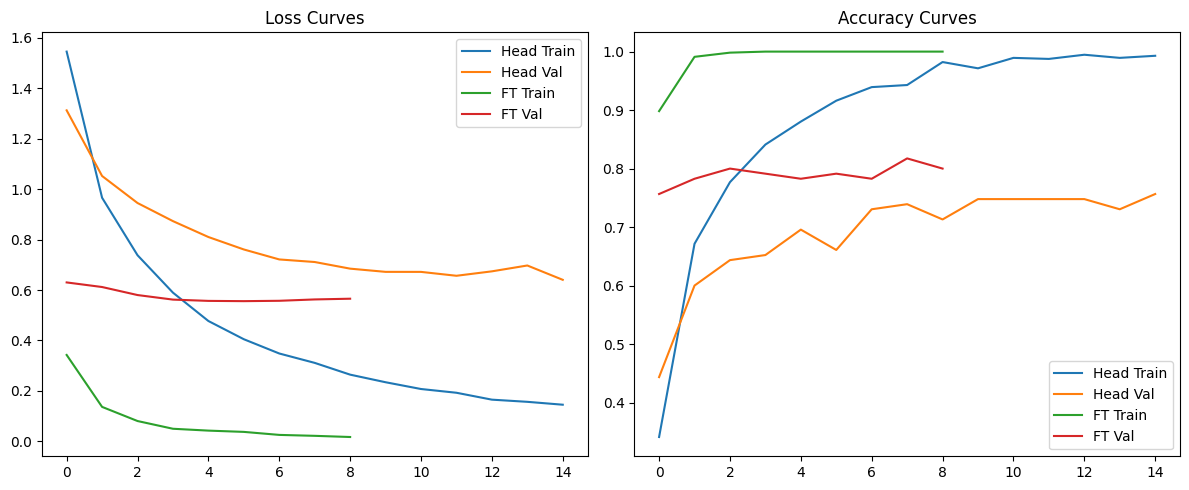

In [13]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(hist_head.history["loss"], label="Head Train")
plt.plot(hist_head.history["val_loss"], label="Head Val")
plt.plot(hist_ft.history["loss"], label="FT Train")
plt.plot(hist_ft.history["val_loss"], label="FT Val")
plt.title("Loss Curves")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(hist_head.history["accuracy"], label="Head Train")
plt.plot(hist_head.history["val_accuracy"], label="Head Val")
plt.plot(hist_ft.history["accuracy"], label="FT Train")
plt.plot(hist_ft.history["val_accuracy"], label="FT Val")
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
print("Saved training curves.")


# **Evaluation**

In [14]:
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Evaluating on test set...


2025-12-12 14:41:15.592828: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_4}}


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7863 - loss: 0.7098
Test loss: 0.6917691826820374
Test accuracy: 0.782608687877655


## **Evaluation Metrics**

In [15]:
y_true = []
y_pred = []
y_prob = []

for X, y in test_ds:
    prob = model.predict(X)
    preds = np.argmax(prob, axis=1)

    y_true.extend(y.numpy())
    y_pred.extend(preds)

    y_prob.extend(prob)  

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob) 

2025-12-12 14:41:43.979458: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-12-12 14:41:49.921267: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-12-12 14:41:55.793302: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


### **Confusion Matrix**

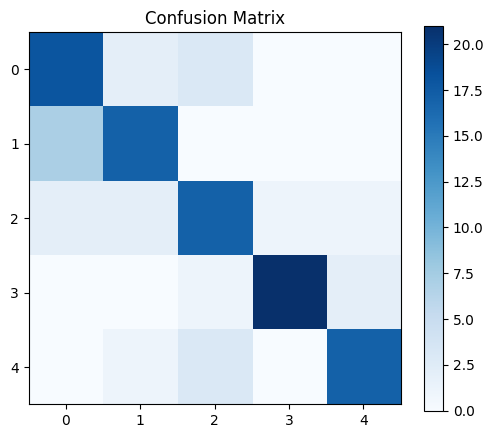

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.savefig("confusion_matrix.png")

### **Classification Report**

In [17]:
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report


Classification Report:



,precision,recall,f1-score,support
0,0.666667,0.782609,0.720000,23.000000
1,0.772727,0.708333,0.739130,24.000000
2,0.708333,0.739130,0.723404,23.000000
3,0.954545,0.875000,0.913043,24.000000
4,0.850000,0.809524,0.829268,21.000000
accuracy,0.782609,0.782609,0.782609,0.782609
macro avg,0.790455,0.782919,0.784969,115.000000
weighted avg,0.790692,0.782609,0.784914,115.000000


### **ROC-AUC**

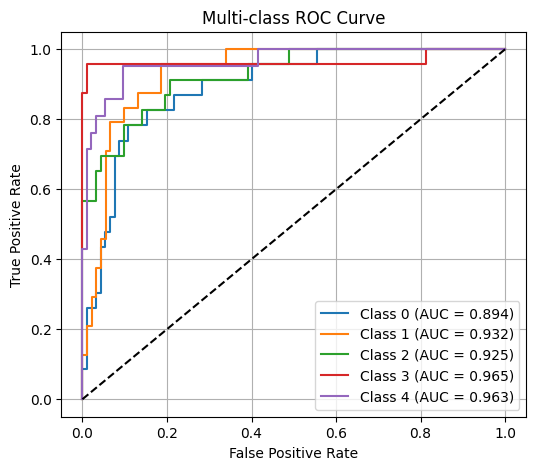

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Extract class labels
classes = np.unique(y_true)
n_classes = len(classes)

# Convert y_true → one-hot (for OvR)
y_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(6, 5))

# For each class plot ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
